Load the data 

In [1]:
# Quick test
path1 = '/home/ubuntu/portiloop-training/usable_preds_0_1707838630.npy'
path2 = '/home/ubuntu/portiloop-training/usable_preds_0_1707838708.npy'

import numpy as np

preds1 = np.load(path1)
preds2 = np.load(path2)

print(preds1.shape)
print(preds2.shape)

# Check that both arrays are equal
print(np.allclose(preds1, preds2))

(150036, 1)
(150036, 1)
False


In [2]:
preds1

array([[1.2115123e-01],
       [1.2115123e-01],
       [1.2115123e-01],
       ...,
       [3.8540470e-06],
       [3.8540470e-06],
       [3.8540470e-06]], dtype=float32)

In [3]:
preds2

array([[2.1035999e-01],
       [2.1035999e-01],
       [2.1035999e-01],
       ...,
       [2.9427192e-06],
       [2.9427192e-06],
       [2.9427192e-06]], dtype=float32)

In [1]:
import os
from portiloopml.portiloop_python.ANN.data.mass_data_new import SubjectLoader

import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt


dataset_path = '/project/MASS/mass_spindles_dataset'

subjects_loader = SubjectLoader(
        os.path.join(dataset_path, 'subject_info.csv'))
subjects = subjects_loader.select_all_subjects()

Get all the spindles and data round them

Time taken to load 01-01-0001: 1.2373290061950684
Time taken to create lookup table: 1.0406508445739746
Number of sampleable indices: 7638447
Number of spindle indexes: 84764
Number of spindles: 527
Number of N1 indexes: 517500
Number of N2 indexes: 3750000
Number of N3 indexes: 862500
Number of R indexes: 1305000
Number of W indexes: 450000


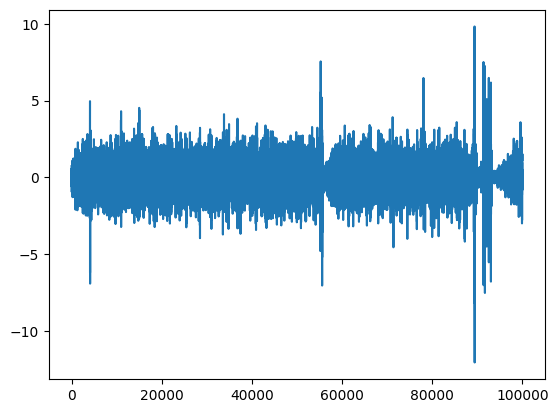

Time taken to load 01-01-0001: 1.321415901184082
Time taken to create lookup table: 1.1598844528198242
Number of sampleable indices: 7638447
Number of spindle indexes: 84764
Number of spindles: 527
Number of N1 indexes: 517500
Number of N2 indexes: 3750000
Number of N3 indexes: 862500
Number of R indexes: 1305000
Number of W indexes: 450000


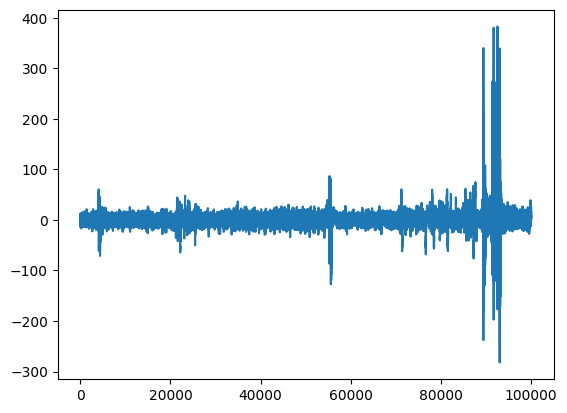

In [2]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import MassDataset

spindles_filtered = []
spindles_unfiltered = []

time_around = 5 # In seconds
buffer_time = 250 * time_around

for subject in subjects:
    # Load the subject Data
    dataset = MassDataset(
        dataset_path,
        subjects=[subject],
        window_size=54,
        seq_stride=42,
        seq_len=1,
        use_filtered=True)
    
    # Get the data around each spindle
    for onset in dataset.data[subject]['spindle_filt_fixed'][subject]['onsets']:
        spindles_filtered.append(dataset.data[subject]['signal'][onset-buffer_time:onset+buffer_time])

    plt.plot(dataset.data[subject]['signal'][100000:200000])
    plt.show()

    dataset = MassDataset(
        dataset_path,
        subjects=[subject],
        window_size=54,
        seq_stride=42,
        seq_len=1,
        use_filtered=False)
    
    # Get the data around each spindle
    for onset in dataset.data[subject]['spindle_mass_fixed'][subject]['onsets']:
        spindles_unfiltered.append(dataset.data[subject]['signal'][onset-buffer_time:onset+buffer_time])

    plt.plot(dataset.data[subject]['signal'][100000:200000])
    plt.show()

    break

In [173]:
import numpy as np
from scipy.signal import butter, filtfilt, hilbert

def compute_sigma_band_envelope(eeg_signal, sampling_rate=250):
    """
    Compute the envelope of the sigma band (11-15 Hz) of an EEG signal.

    Parameters:
    - eeg_signal: 1D NumPy array representing the EEG signal.
    - sampling_rate: Sampling rate of the EEG signal.

    Returns:
    - envelope: NumPy array representing the envelope of the sigma band.
    """

    # Define sigma band frequencies
    sigma_band = [11, 16]

    # Step 1: Bandpass filter
    def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data)
        return y

    filtered_signal = butter_bandpass_filter(eeg_signal, sigma_band[0], sigma_band[1], sampling_rate)

    # Step 2: Calculate power
    power_signal = np.abs(hilbert(filtered_signal))**2

    # Step 3: Apply smoothing (e.g., moving average)
    window_size = int(sampling_rate * 0.2)  # 200 ms window (adjust as needed)
    envelope = np.convolve(power_signal, np.ones(window_size)/window_size, mode='valid')

    return envelope

In [ ]:
# Test the output of the filter

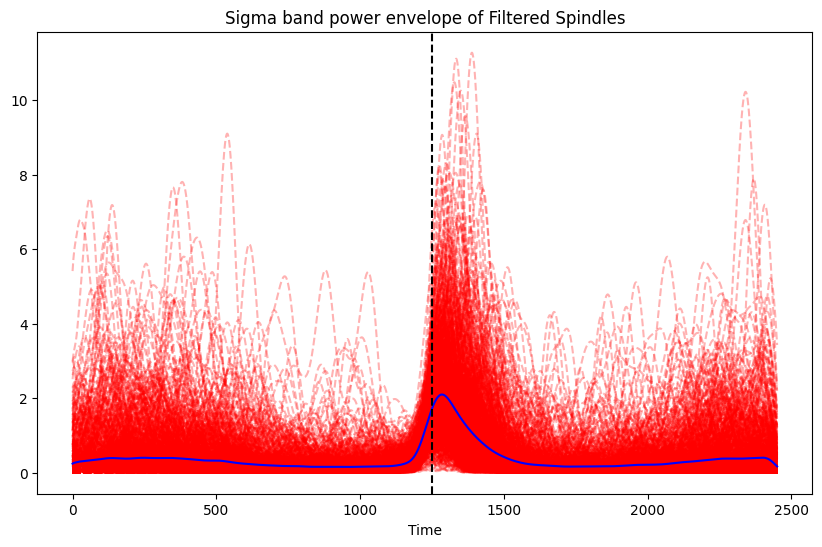

In [6]:
# Plot the original signal and its envelope
plt.figure(figsize=(10, 6))

averages = []

for signal in spindles_filtered:
    signal_filt = compute_sigma_band_envelope(signal)
    averages.append(signal_filt)
    # plt.plot(signal, label='Original Signal', alpha=0.5)
    plt.plot(signal_filt, linestyle='--', color='red', alpha=0.3)

average = np.mean(np.array(averages), axis=0)
plt.plot(average, color='blue')

# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Filtered Spindles')
plt.xlabel('Time')
plt.show()

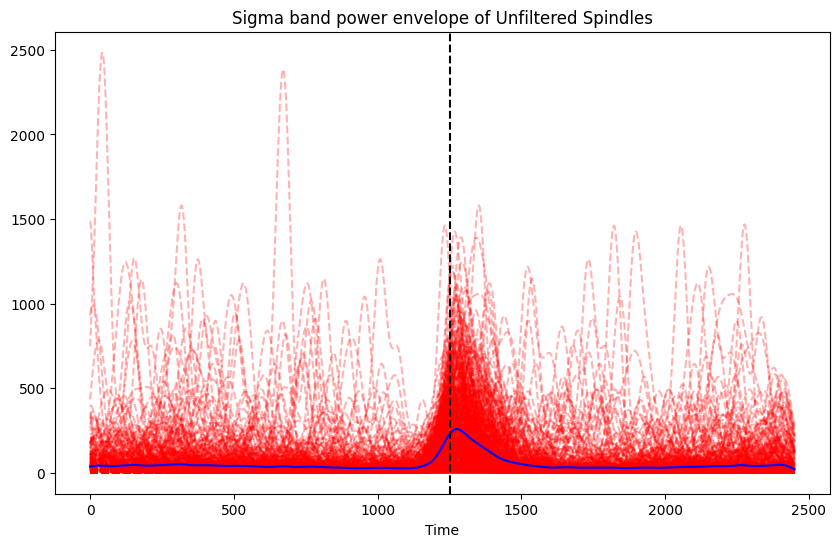

In [7]:
# Plot the original signal and its envelope
plt.figure(figsize=(10, 6))

averages = []

for signal in spindles_unfiltered:
    signal_filt = compute_sigma_band_envelope(signal)
    averages.append(signal_filt)
    # plt.plot(signal, label='Original Signal', alpha=0.5)
    plt.plot(signal_filt, linestyle='--', color='red', alpha=0.3)

average = np.mean(np.array(averages), axis=0)
plt.plot(average, color='blue')


# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Unfiltered Spindles')
plt.xlabel('Time')
plt.show()

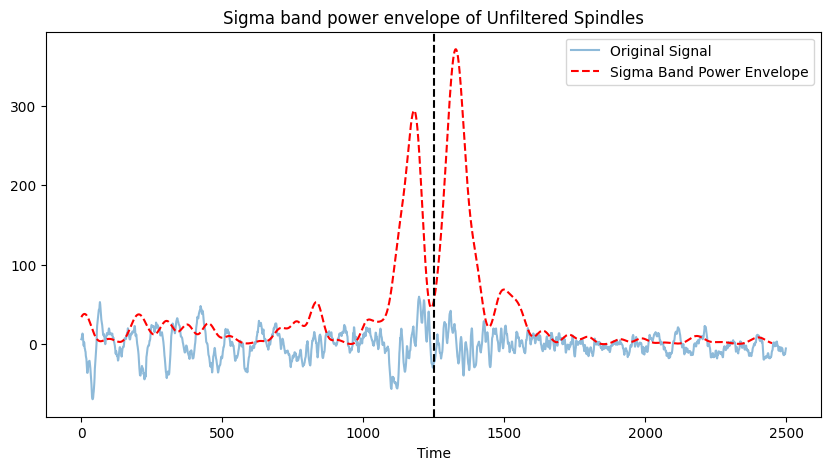

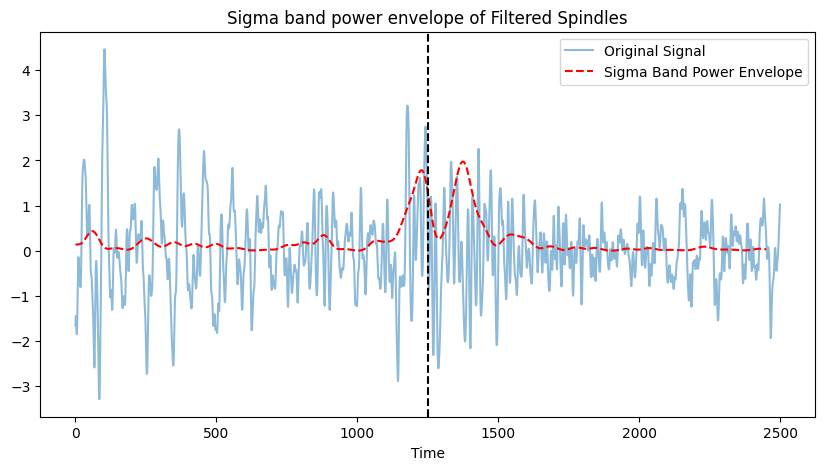

In [8]:
plt.figure(figsize=(10, 5))
signal = spindles_unfiltered[0]
plt.plot(signal, label='Original Signal', alpha=0.5)
signal_filt = compute_sigma_band_envelope(signal)
plt.plot(signal_filt, linestyle='--', color='red', label='Sigma Band Power Envelope')
# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Unfiltered Spindles')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
signal = spindles_filtered[0]
plt.plot(signal, label='Original Signal', alpha=0.5)
signal_filt = compute_sigma_band_envelope(signal)
plt.plot(signal_filt, linestyle='--', color='red', label='Sigma Band Power Envelope')
# Add a vertical line in the middle
plt.axvline(x=len(signal)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Filtered Spindles')
plt.xlabel('Time')
plt.legend()
plt.show()


In [20]:
average

array([0.244361  , 0.24961352, 0.25393543, ..., 0.18398126, 0.1765724 ,
       0.16930668])

In [52]:
onsets_filt = dataset.data[subject]['spindle_filt_fixed'][subject]['onsets']
onsets_mass = dataset.data[subject]['spindle_mass_fixed'][subject]['onsets']

from portiloopml.portiloop_python.ANN.wamsley_utils import binary_f1_score

precision, recall, f1, tp, fp, fn, closest = binary_f1_score(
    onsets_mass, 
    onsets_filt,
    sampling_rate=250, 
    min_time_positive=0.5)

In [53]:
tp, fp, fn

(254, 792, 273)

In [54]:
len(onsets_mass)

527

## Check the Wamsley Online Spindle

In [4]:
from portiloopml.portiloop_python.ANN.wamsley_utils import binary_f1_score, detect_wamsley, RMS_score
from portiloopml.portiloop_python.ANN.data.mass_data_new import MassDataset


In [9]:
dataset_path = '/project/MASS/mass_spindles_dataset'
subject = '01-02-0002'
dataset = MassDataset(
        dataset_path,
        subjects=[subject],
        window_size=54,
        seq_stride=42,
        seq_len=1,
        use_filtered=False)

Time taken to load 01-02-0002: 3.7805216312408447
Time taken to create lookup table: 0.9905261993408203
Number of sampleable indices: 8753947
Number of spindle indexes: 169797
Number of spindles: 909
Number of N1 indexes: 345000
Number of N2 indexes: 4555000
Number of N3 indexes: 1335000
Number of R indexes: 1000000
Number of W indexes: 550000


In [171]:
signal = dataset.data[subject]['signal']
wamsley_spindles = dataset.data[subject]['spindle_mass_fixed'][subject]['onsets']
ss_labels = dataset.data[subject]['ss_label']
mask = (ss_labels == 1) | (ss_labels == 2)

In [165]:
import copy

from portiloopml.portiloop_python.ANN.wamsley_utils import _detect_start_end, _merge_close, morlet_transform, remove_straddlers, smooth, within_duration

def detect_wamsley(data, mask, sampling_rate=250, thresholds=None, fixed=True, squarred=True, remove_outliers=False, threshold_multiplier=4.5):
    """
    Detect spindles in the data using the method described in Wamsley et al. 2012
    :param data: The data to detect spindles in
    :param mask: The mask to apply to the data to keep only N2, N3 sleep
    :param sampling_rate: The sampling rate of the data
    :param thresholds: The past thresholds to use for the moving average
    """
    if fixed:
        frequency = (11, 16)
    else:
        frequency = (12, 15)

    duration = (0.3, 3)
    wavelet_options = {'f0': np.mean(frequency),
                       'sd': .8,
                       'dur': 1.,
                       'output': 'complex'
                       }
    smooth_duration = .1
    det_thresh = threshold_multiplier
    merge_thresh = 0.3
    min_interval = 0.5  # minimum time in seconds between events

    thresholds = copy.deepcopy(thresholds)

    # First, we transform the signal using wavelet transform
    if mask is None:
        data_detect = data
    else:
        data_detect = data[mask]

    # If the data is too short, return an empty array
    if len(data_detect) <= 30 * 250:
        return np.array([]), None, None, None, thresholds

    if mask is None:
        timestamps = np.arange(0, len(data)) / sampling_rate
    else:
        timestamps = (np.arange(0, len(data)))[mask] / sampling_rate
    assert len(data_detect) == len(timestamps)

    wavelet = 'morl'
    fs = 250  # Sampling frequency in hz
    frequencies = list(range(11, 17))
    frequencies_norm = np.array(frequencies) / fs  # normalize
    scales = pywt.frequency2scale(wavelet, frequencies_norm)

    data_detect = pywt.cwt(data_detect, scales, 'morl')[0]
    data_detect = np.mean(np.abs(data_detect), axis=0)

    # data_detect = morlet_transform(data_detect, sampling_rate, wavelet_options)

    # if fixed:
    #     if squarred:
    #         data_detect = np.real(data_detect ** 2) 
    #     else:
    #         data_detect = np.real(data_detect)
    # else:
    #     data_detect = np.real(data_detect ** 2) ** 2

    # Then we smoothen out the signal
    data_detect = smooth(data_detect, smooth_duration, sampling_rate)

    # if fixed:
    #     data_detect = np.abs(data_detect)

    mean_spindle_power = np.mean(data_detect)

    if remove_outliers:
        # Remove the outliers
        data_detect_no_outlier = np.clip(
            data_detect, 0, 2 * mean_spindle_power)
        mean_spindle_power = np.mean(data_detect_no_outlier)

    # Then, we define the threshold
    _threshold = det_thresh * mean_spindle_power
    if thresholds is None:
        threshold = _threshold
    else:
        thresholds.append((_threshold, len(data_detect)))

        # Compute the weighted average of the thresholds to get the current threshold
        weigths = np.array([i[1] for i in thresholds])
        weigths = weigths / np.sum(weigths)
        threshold = np.sum([i[0] * j for i, j in zip(thresholds, weigths)])

    # Then we find the peaks
    peaks = data_detect >= threshold

    # Get the start, end and peak power index of each spindle
    events = _detect_start_end(peaks)

    # If no events are found, return an empty array
    if events is None:
        return np.array([]), _threshold, threshold, data_detect, thresholds

    # add the location of the peak in the middle
    events = np.insert(events, 1, 0, axis=1)
    for i in events:
        i[1] = i[0] + np.argmax(data_detect[i[0]:i[2]])

    # Merge the events that are too close
    events = _merge_close(data_detect, events, timestamps, min_interval)
    # Filter the events based on duration
    events = within_duration(events, timestamps, duration)
    # Remove the events that straddle a stitch
    events = remove_straddlers(events, timestamps, sampling_rate)

    # Get the real indexes back
    def to_index(point):
        return timestamps[point] * sampling_rate

    if len(events) == 0:
        return np.array([]), _threshold, threshold, data_detect, thresholds

    events = np.vectorize(to_index)(events)

    return events.astype(int), _threshold, threshold, data_detect, thresholds

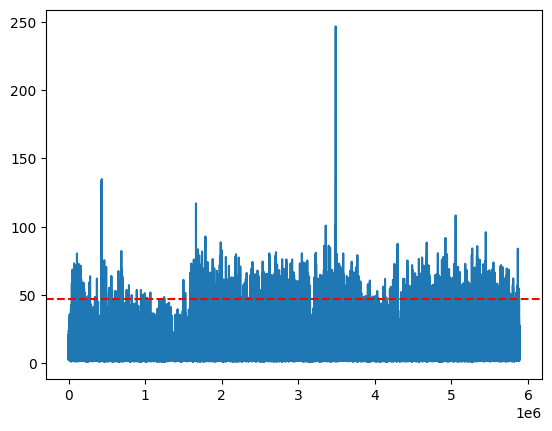

In [156]:
# GEt the spindles
# events_not_fixed, _threshold_not_fixed, threshold, data_detect_not_fixed, thresholds = detect_wamsley(
#     signal, 
#     mask, 
#     sampling_rate=250,
#     fixed=False)

# events_not_fixed = [event[0] for event in events_not_fixed]

# events_fixed, _threshold_fixed, threshold, data_detect_fixed, thresholds = detect_wamsley(
#     signal, 
#     mask, 
#     sampling_rate=250,
#     fixed=True, 
#     squarred=False)

# events_fixed = [event[0] for event in events_fixed]

events_fixed_squarred, _threshold_fixed_squarred, threshold, data_detect_fixed_squarred, thresholds = detect_wamsley(
    signal, 
    mask, 
    sampling_rate=250,
    fixed=True, 
    squarred=True,
    remove_outliers=True, 
    threshold_multiplier=4.5)

events_fixed_squarred = [event[0] for event in events_fixed_squarred]

# events_no_outlier, _threshold_no_outlier, threshold, data_detect_no_outlier, thresholds = detect_wamsley(
#     signal, 
#     mask, 
#     sampling_rate=250,
#     fixed=False, 
#     squarred=False,
#     remove_outliers=True)

# events_no_outlier = [event[0] for event in events_no_outlier]

# event_fixed_no_outlier, _threshold_fixed_no_outlier, threshold, data_detect_fixed_no_outlier, thresholds = detect_wamsley(
#     signal, 
#     mask, 
#     sampling_rate=250,
#     fixed=True, 
#     squarred=False,
#     remove_outliers=True)

# events_fixed_no_outlier = [event[0] for event in event_fixed_no_outlier]

# events_no_outlier_squarred, _threshold_no_outlier_squarred, threshold, data_detect_no_outlier_squarred, thresholds = detect_wamsley(
#     signal, 
#     mask, 
#     sampling_rate=250,
#     fixed=True, 
#     squarred=True,
#     remove_outliers=True)

# events_no_outlier_squarred = [event[0] for event in events_no_outlier_squarred]

In [158]:
len(events_fixed_squarred)

340

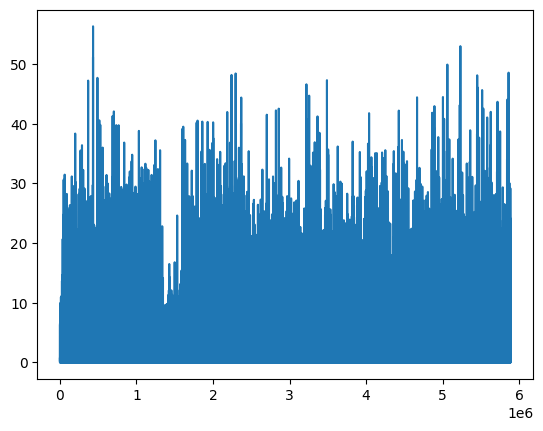

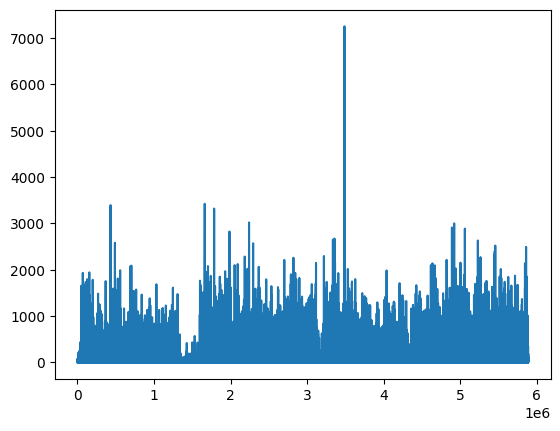

In [59]:
plt.plot(data_detect_fixed, label='Fixed')
plt.show()

plt.plot(data_detect_fixed_squarred, label='Fixed Squarred')
plt.show()

In [46]:
print(f"Fixed found {len(events_fixed)} spindles")
print(f"Not Fixed found {len(events_not_fixed)} spindles")
print(f"Fixed Squarred found {len(events_fixed_squarred)} spindles")
print(f"Fixed no outlier found {len(events_fixed_no_outlier)} spindles")
print(f"Not fixed no outlier found {len(events_no_outlier)} spindles")
print(f"Fixed no outlier squarred found {len(events_no_outlier_squarred)} spindles")

Fixed found 1735 spindles
Not Fixed found 2242 spindles
Fixed Squarred found 3259 spindles
Fixed no outlier found 909 spindles
Not fixed no outlier found 1999 spindles
Fixed no outlier squarred found 1936 spindles


In [161]:
from scipy.signal import fftconvolve, filtfilt, firwin, kaiserord, kaiser_atten, kaiser_beta
import torch

def RMS_score(candidate, Fs=250, lowcut=11, highcut=16):

    # Filter the signal
    stopbbanAtt = 60  # stopband attenuation of 60 dB.
    width = .5  # This sets the cutoff width in Hertz
    nyq = 0.5 * Fs
    ntaps, _ = kaiserord(stopbbanAtt, width/nyq)
    atten = kaiser_atten(ntaps, width/nyq)
    beta = kaiser_beta(atten)
    a = 1.0
    taps = firwin(ntaps, [lowcut, highcut], nyq=nyq,
                  pass_zero=False, window=('kaiser', beta), scale=False)
    filtered_signal = filtfilt(taps, a, candidate)

    # Get the baseline and the detection window for the RMS
    detect_index = len(candidate) // 2
    size_window = int(0.5 * Fs)
    baseline_idx = -2 * Fs  # Index compared to the detection window
    baseline = filtered_signal[detect_index +
                               baseline_idx:detect_index + baseline_idx + size_window]
    detection = filtered_signal[detect_index:detect_index + size_window]

    baseline = torch.tensor(baseline.copy())
    detection = torch.tensor(detection.copy())

    # Calculate the RMS
    baseline_rms = torch.sqrt(torch.mean(torch.square(baseline)))
    detection_rms = torch.sqrt(torch.mean(torch.square(detection)))

    score = detection_rms / baseline_rms
    return score

In [153]:
# Get all the ten second intervals around the spindles
spindles_fixed = []
spindles_not_fixed = []
spindles_fixed_squarred = []
spindles_no_outlier = []
spindles_no_outlier_squarred = []
spindles_fixed_no_outlier = []

time_around = 30 # In seconds
buffer_time = 250 * time_around

# for onset in events_fixed:
#     spindles_fixed.append(signal[onset-buffer_time:onset+buffer_time])

# for onset in events_not_fixed:
#     spindles_not_fixed.append(signal[onset-buffer_time:onset+buffer_time])

for onset in events_fixed_squarred:
    spindles_fixed_squarred.append(signal[onset-buffer_time:onset+buffer_time])

# for onset in events_no_outlier:
#     spindles_no_outlier.append(signal[onset-buffer_time:onset+buffer_time])

# for onset in events_fixed_no_outlier:
#     spindles_fixed_no_outlier.append(signal[onset-buffer_time:onset+buffer_time])

# for onset in events_no_outlier_squarred:
#     spindles_no_outlier_squarred.append(signal[onset-buffer_time:onset+buffer_time])

Doing Threshold 3


Got 1560 spindles


/tmp/ipykernel_1704517/2220824204.py:14: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  taps = firwin(ntaps, [lowcut, highcut], nyq=nyq,


Got an average score of 5.490603838369309
Doing Threshold 3.5
Got 989 spindles
Got an average score of 6.210950441451474
Doing Threshold 4
Got 595 spindles
Got an average score of 6.8902421508523375
Doing Threshold 4.5
Got 340 spindles
Got an average score of 7.620558370551339
Doing Threshold 5
Got 174 spindles
Got an average score of 8.48588499563549


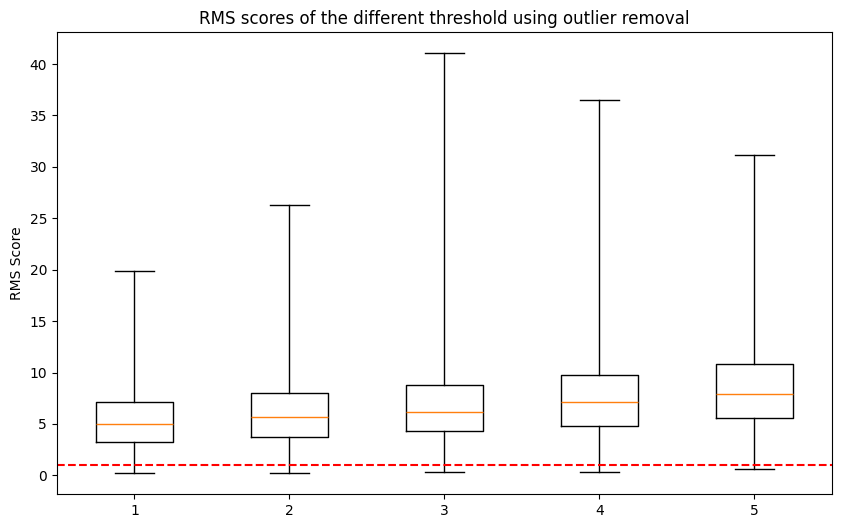

In [164]:
from tqdm import tqdm

scores = []
thresholds = [3, 3.5, 4, 4.5, 5]
for threshold in thresholds:
    print(f"Doing Threshold {threshold}")
    events_fixed_squarred, _threshold_fixed_squarred, threshold, data_detect_fixed_squarred, thresholds = detect_wamsley(
        signal, 
        mask, 
        sampling_rate=250,
        fixed=True, 
        squarred=True,
        remove_outliers=True, 
        threshold_multiplier=threshold)

    print(f"Got {len(events_fixed_squarred)} spindles")

    time_around = 30 # In seconds
    buffer_time = 250 * time_around
    events_fixed_squarred = [event[0] for event in events_fixed_squarred]
    spindles_fixed_squarred = []
    for onset in events_fixed_squarred:
        spindles_fixed_squarred.append(signal[onset-buffer_time:onset+buffer_time])
    
    score = []
    for spindle in spindles_fixed_squarred:
        score.append(RMS_score(torch.from_numpy(spindle)))
    scores.append(score)
    print(f"Got an average score of {np.mean(score)}")

In [206]:
thresholds = [3, 3.5, 4, 4.5, 5]

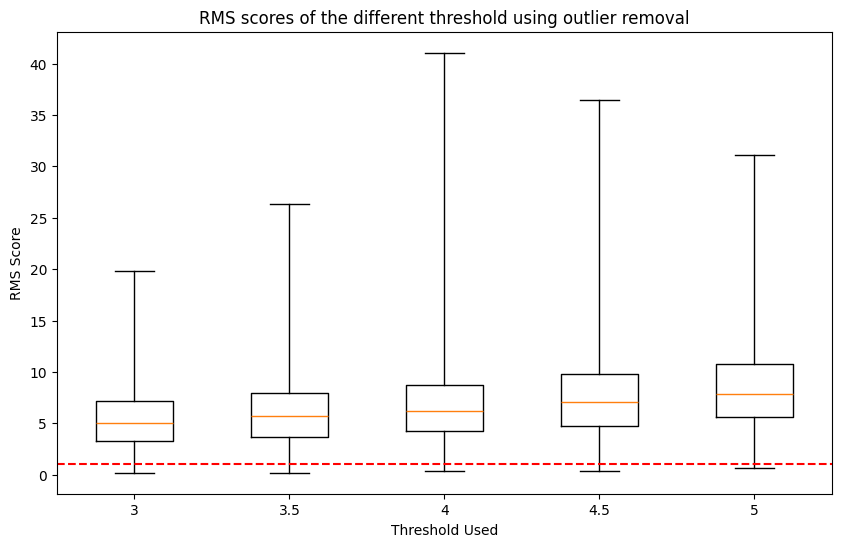

In [208]:
# Do a boxplot of the RMS scores
plt.figure(figsize=(10, 6))
# plt.boxplot([scores_fixed, scores_not_fixed, scores_fixed_squarred, scores_no_outlier, scores_no_outlier_squarred, scores_fixed_no_outlier], whis=1000)
plt.boxplot(scores, whis=1000)

plt.xticks([1, 2, 3, 4, 5], [f"{t}" for t in thresholds])

plt.title('RMS scores of the different threshold using outlier removal')
plt.ylabel('RMS Score')
plt.xlabel('Threshold Used')
# Add a horizontal line at 1
plt.axhline(y=1, color='red', linestyle='--')
plt.show()

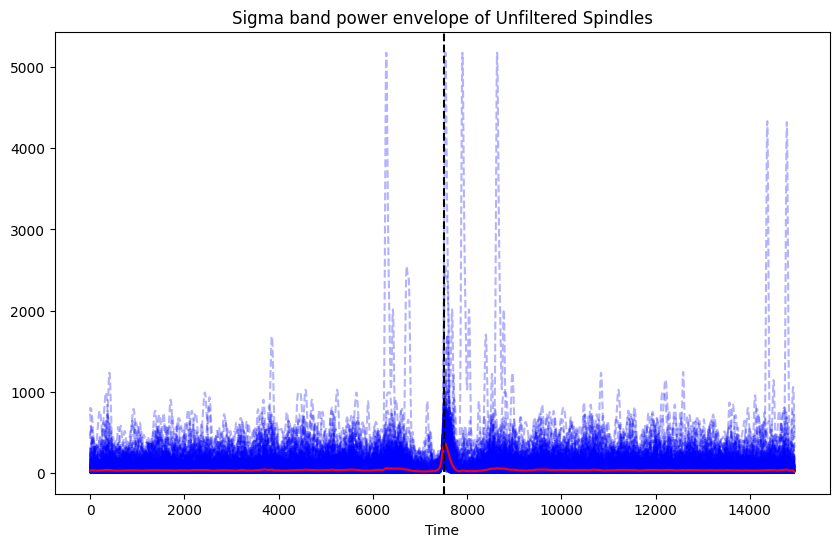

In [175]:
events_fixed_squarred, _threshold_fixed_squarred, threshold, data_detect_fixed_squarred, thresholds = detect_wamsley(
        signal, 
        mask, 
        sampling_rate=250,
        fixed=True, 
        squarred=True,
        remove_outliers=True, 
        threshold_multiplier=4)
events_fixed_squarred = [event[0] for event in events_fixed_squarred]
spindles_fixed_squarred = []
for onset in events_fixed_squarred:
    spindles_fixed_squarred.append(signal[onset-buffer_time:onset+buffer_time])

# Plot the original signal and its envelope
plt.figure(figsize=(10, 6))

averages = []

for sig in spindles_fixed_squarred:
    signal_filt = compute_sigma_band_envelope(sig)
    averages.append(signal_filt)
    # plt.plot(signal, label='Original Signal', alpha=0.5)
    plt.plot(signal_filt, linestyle='--', color='blue', alpha=0.3)

average = np.mean(np.array(averages), axis=0)
plt.plot(average, color='red')


# Add a vertical line in the middle
plt.axvline(x=len(sig)/2, color='black', linestyle='--')
plt.title('Sigma band power envelope of Unfiltered Spindles')
plt.xlabel('Time')
plt.show()

In [196]:
np.where(np.array(scores[2]) < 1)

(array([  0, 166, 171, 232, 238, 349]),)

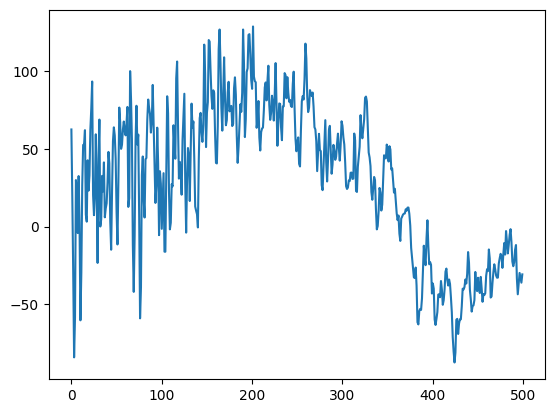

In [202]:
plt.plot(spindles_fixed_squarred[349][len(spindles_fixed_squarred[10])//2-250:len(spindles_fixed_squarred[10])//2+250])

In [154]:
def get_rmss(spindle_list):
    return [RMS_score(torch.from_numpy(spindle)) for spindle in spindle_list]

# # Get the RMS score of each spindle
# scores_fixed = [RMS_score(torch.from_numpy(spindle)) for spindle in tqdm(spindles_fixed)]
# scores_not_fixed = [RMS_score(torch.from_numpy(spindle)) for spindle in tqdm(spindles_not_fixed)]
scores_fixed_squarred_2 = [RMS_score(torch.from_numpy(spindle)) for spindle in tqdm(spindles_fixed_squarred)]
# scores_no_outlier = [RMS_score(torch.from_numpy(spindle)) for spindle in tqdm(spindles_no_outlier)]
# scores_no_outlier_squarred = [RMS_score(torch.from_numpy(spindle)) for spindle in tqdm(spindles_no_outlier_squarred)]
# scores_fixed_no_outlier = [RMS_score(torch.from_numpy(spindle)) for spindle in tqdm(spindles_fixed_no_outlier)]

/tmp/ipykernel_1704517/2220824204.py:14: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  taps = firwin(ntaps, [lowcut, highcut], nyq=nyq,
100%|██████████| 203/203 [00:47<00:00,  4.25it/s]


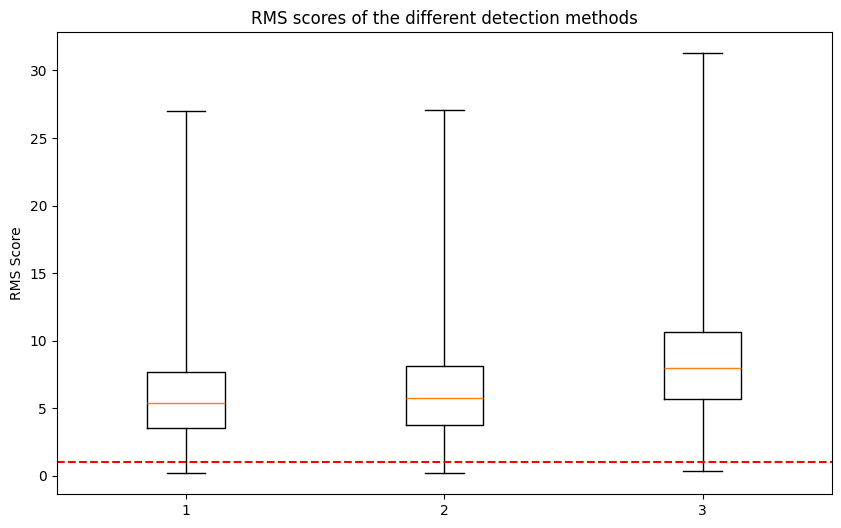

In [155]:
import matplotlib.pyplot as plt
import numpy as np



In [28]:
import numpy as np
print(f"Fixed: {np.mean(scores_fixed)}")
print(f"Not Fixed: {np.mean(scores_not_fixed)}")
print(f"Fixed Squarred: {np.mean(scores_fixed_squarred)}")
print(f"Fixed no outlier: {np.mean(scores_fixed_no_outlier)}")
print(f"Not fixed no outlier: {np.mean(scores_no_outlier)}")
print(f"Fixed no outlier squarred: {np.mean(scores_no_outlier_squarred)}")


Fixed: 5.151346163165258
Not Fixed: 7.667981640429623
Fixed Squarred: 5.9122737542001715
Fixed no outlier: 5.185835639396482
Not fixed no outlier: 5.9229514006306205
Fixed no outlier squarred: 5.632494701112797


# Check the Online filtering

In [55]:
import numpy as np
from scipy.signal import firwin

def shift_numpy(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

class FIR:
    def __init__(self, nb_channels, coefficients, buffer=None):
        
        self.coefficients = np.expand_dims(np.array(coefficients), axis=1)
        self.taps = len(self.coefficients)
        self.nb_channels = nb_channels
        self.buffer = np.array(buffer) if buffer is not None else np.zeros((self.taps, self.nb_channels))
    
    def filter(self, x):
        self.buffer = shift_numpy(self.buffer, 1, x)
        filtered = np.sum(self.buffer * self.coefficients, axis=0)
        return filtered

    
class FilterPipeline:
    def __init__(self,
                 nb_channels,
                 sampling_rate,
                 power_line_fq=60,
                 use_custom_fir=False,
                 custom_fir_order=20,
                 custom_fir_cutoff=30,
                 alpha_avg=0.1,
                 alpha_std=0.001,
                 epsilon=0.000001,
                 filter_args=[]):
        if len(filter_args) > 0:
            use_fir, use_notch, use_std = filter_args
        else:
            use_fir=True,
            use_notch=False,
            use_std=True
        self.use_fir = use_fir
        self.use_notch = use_notch
        self.use_std = use_std
        self.nb_channels = nb_channels
        assert power_line_fq in [50, 60], f"The only supported power line frequencies are 50 Hz and 60 Hz"
        if power_line_fq == 60:
            self.notch_coeff1 = -0.12478308884588535
            self.notch_coeff2 = 0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.12478308884588535
            self.notch_coeff5 = 0.99364593398236511
        else:
            self.notch_coeff1 = -0.61410695998423581
            self.notch_coeff2 =  0.98729186796473023
            self.notch_coeff3 = 0.99364593398236511
            self.notch_coeff4 = -0.61410695998423581
            self.notch_coeff5 = 0.99364593398236511
        self.dfs = [np.zeros(self.nb_channels), np.zeros(self.nb_channels)]
        
        self.moving_average = None
        self.moving_variance = np.zeros(self.nb_channels)
        self.ALPHA_AVG = alpha_avg
        self.ALPHA_STD = alpha_std
        self.EPSILON = epsilon
        
        if use_custom_fir:
            self.fir_coef = firwin(numtaps=custom_fir_order+1, cutoff=custom_fir_cutoff, fs=sampling_rate)
        else:
            self.fir_coef = [
                0.001623780150148094927192721215192250384,
                0.014988684599373741992978104065059596905,
                0.021287595318265635502275046064823982306,
                0.007349500393709578957568417933998716762,
                -0.025127515717112181709014251396183681209,
                -0.052210507359822452833064687638398027048,
                -0.039273839505489904766477593511808663607,
                0.033021568427940004020193498490698402748,
                0.147606943281569008563636202779889572412,
                0.254000252034505602516389899392379447818,
                0.297330876398883392486283128164359368384,
                0.254000252034505602516389899392379447818,
                0.147606943281569008563636202779889572412,
                0.033021568427940004020193498490698402748,
                -0.039273839505489904766477593511808663607,
                -0.052210507359822452833064687638398027048,
                -0.025127515717112181709014251396183681209,
                0.007349500393709578957568417933998716762,
                0.021287595318265635502275046064823982306,
                0.014988684599373741992978104065059596905,
                0.001623780150148094927192721215192250384]
        self.fir = FIR(self.nb_channels, self.fir_coef)
        
    def filter(self, value):
        """
        value: a numpy array of shape (data series, channels)
        """
        for i, x in enumerate(value):  # loop over the data series
            # FIR:
            if self.use_fir:
                x = self.fir.filter(x)
            # notch:
            if self.use_notch:
                denAccum = (x - self.notch_coeff1 * self.dfs[0]) - self.notch_coeff2 * self.dfs[1]
                x = (self.notch_coeff3 * denAccum + self.notch_coeff4 * self.dfs[0]) + self.notch_coeff5 * self.dfs[1]
                self.dfs[1] = self.dfs[0]
                self.dfs[0] = denAccum
            # standardization:
            if self.use_std:
                if self.moving_average is not None:
                    delta = x - self.moving_average
                    self.moving_average = self.moving_average + self.ALPHA_AVG * delta
                    self.moving_variance = (1 - self.ALPHA_STD) * (self.moving_variance + self.ALPHA_STD * delta**2)
                    moving_std = np.sqrt(self.moving_variance)
                    x = (x - self.moving_average) / (moving_std + self.EPSILON)
                else:
                    self.moving_average = x
            value[i] = x
        return value

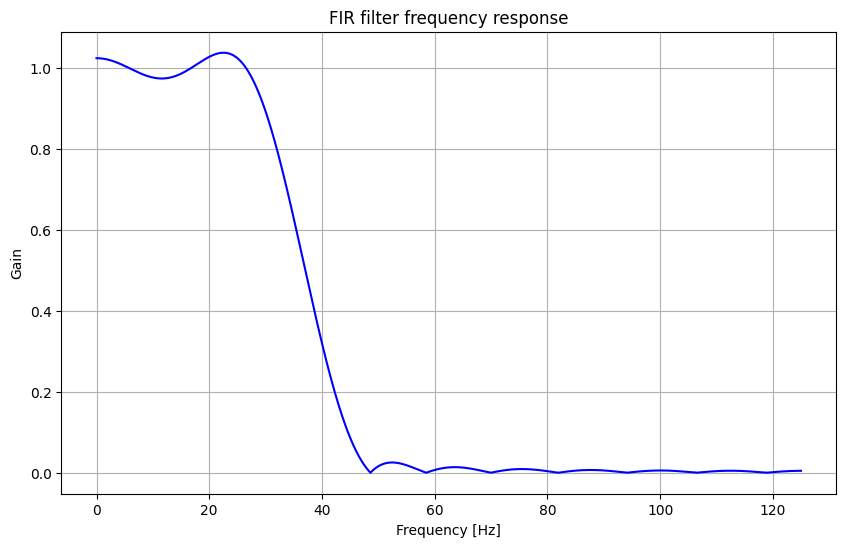

In [58]:
# Make a filter reponse plot for the FIR filter
import matplotlib.pyplot as plt
from scipy.signal import freqz

filter = FilterPipeline(nb_channels=1, sampling_rate=250)

# Plot the frequency response.
w, h = freqz(filter.fir_coef, worN=8000)

plt.figure(figsize=(10, 6))
plt.plot(0.5 * 250 * w / np.pi, np.abs(h), 'b')
plt.title("FIR filter frequency response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()


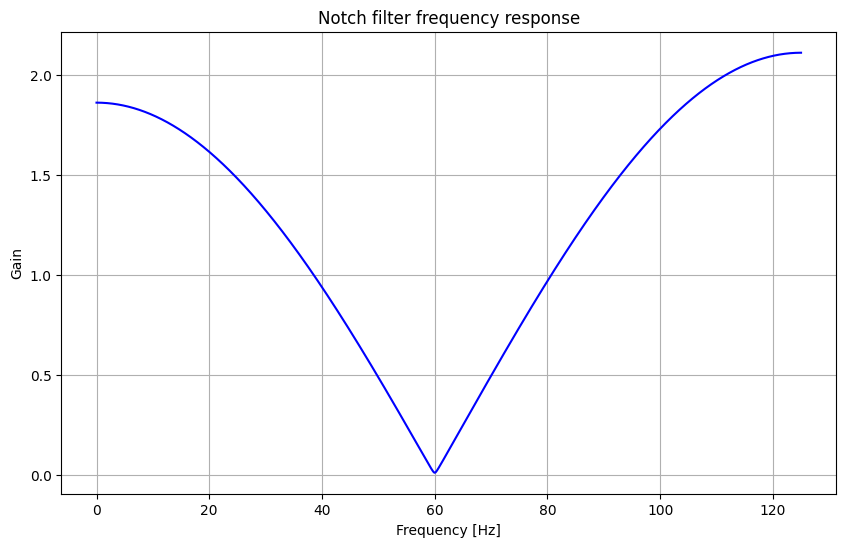

In [59]:
# Make the frequency response plot for the notch filter
from scipy.signal import freqz
import matplotlib.pyplot as plt

# Plot the frequency response.
w, h = freqz([1, filter.notch_coeff1, filter.notch_coeff2], worN=8000)

plt.figure(figsize=(10, 6))
plt.plot(0.5 * 250 * w / np.pi, np.abs(h), 'b')
plt.title("Notch filter frequency response")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()